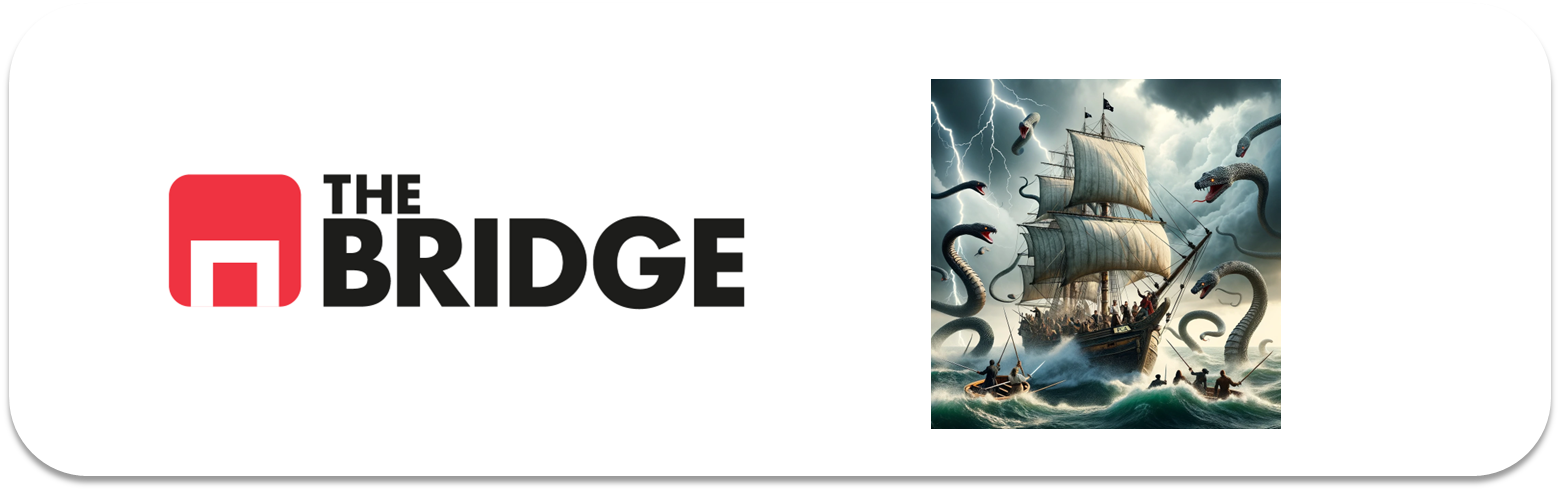

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

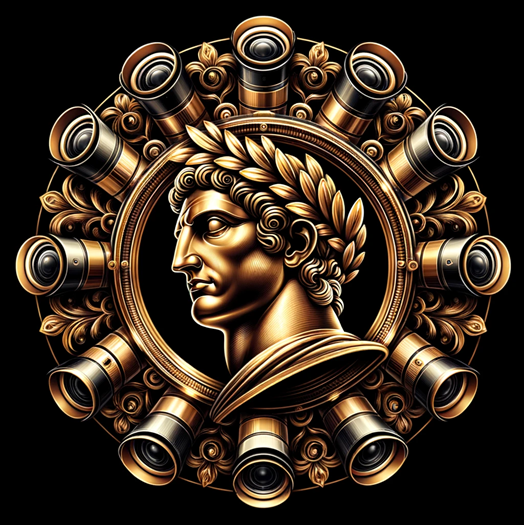

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import funciones_ML as bt
import seaborn as sns
import cv2
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale, StandardScaler
from matplotlib.colors import ListedColormap






### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




olivetti_faces.data: Contiene los datos de las imágenes, con una forma de (n_samples, n_features).<br>
olivetti_faces.images: Contiene las imágenes como matrices NumPy, con una forma de (n_samples, 64, 64).<br>
olivetti_faces.target: Contiene las etiquetas de las imágenes, con una forma de (n_samples,).<br>

In [2]:
olivetti_faces = fetch_olivetti_faces()
data=olivetti_faces.data
target=olivetti_faces.target

In [3]:
#df1=pd.DataFrame(data)
df2=pd.DataFrame(target)

In [4]:
df2.shape #hay del 0 al 39 quye son las etiquetas del total de imagenes

(400, 1)

In [5]:
df=pd.DataFrame(olivetti_faces.data)



In [6]:
#definitivo df
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554


In [7]:
X= df
y= df2

In [8]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

-   MINIEDA
-   Al tener un total de 4096 columnas con una distribucion numerica muy similar con valores cercanos a 0 , no voy a realziar el EDA ya que no voy a descartar ninguna de las columnas   

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,400.0,0.400134,0.180695,0.086777,0.243802,0.392562,0.528926,0.805785
1,400.0,0.434236,0.189504,0.066116,0.267562,0.458678,0.575413,0.822314
2,400.0,0.476281,0.194742,0.090909,0.314050,0.512397,0.636364,0.871901
3,400.0,0.518481,0.193313,0.041322,0.383264,0.545455,0.666322,0.892562
4,400.0,0.554845,0.188593,0.107438,0.446281,0.584711,0.702479,0.871901
...,...,...,...,...,...,...,...,...
4091,400.0,0.338657,0.189256,0.012397,0.177686,0.314050,0.462810,0.863636
4092,400.0,0.335909,0.195280,0.049587,0.173554,0.299587,0.462810,0.921488
4093,400.0,0.321415,0.187842,0.057851,0.173554,0.289256,0.446281,0.929752
4094,400.0,0.313647,0.183616,0.061983,0.173554,0.270661,0.414256,0.884298


In [10]:
df.shape

(400, 4096)

In [11]:
# Definir el model_xgbclf de clasificacion
from xgboost import XGBClassifier
model_xgbclf = XGBClassifier(tree_method='hist', device='gpu', random_state=42)

# Validación cruzada con 5 folds garantizando que tengan la misma proporcion de muestras cada uno
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Calcular la "balanced accuracy" en la validación cruzada en el conjunto de entrenamiento
balancy_accuracy_train_cv = cross_val_score(model_xgbclf, X_train, y_train, cv=cv, scoring='balanced_accuracy')


# Ajustar el model_xgbclf a los datos de entrenamiento
model_xgbclf.fit(X_train, y_train)

# Calcular la "balanced accuracy" en el conjunto de prueba
y_pred_test = model_xgbclf.predict(X_test)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)

#validacion cruzada al test
balancy_accuracy_test_cv = cross_val_score(model_xgbclf, X_test, y_test, cv=cv, scoring='balanced_accuracy')


# Imprimir los resultados
print("Balanced accuracy en validación cruzada train(5 folds):")
print(balancy_accuracy_train_cv)
print("Balanced accuracy en validación cruzada test(5 folds):")
print(balancy_accuracy_test_cv)
print(f"media de Balanced accuracy test: {balanced_accuracy_test}")


c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [19:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Balanced accuracy en validación cruzada train(5 folds):
[0.61875 0.69375]
Balanced accuracy en validación cruzada test(5 folds):
[0.025 0.025]
media de Balanced accuracy test: 0.8


C:\Users\victo\AppData\Local\Temp\ipykernel_17360\3918197207.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 10)


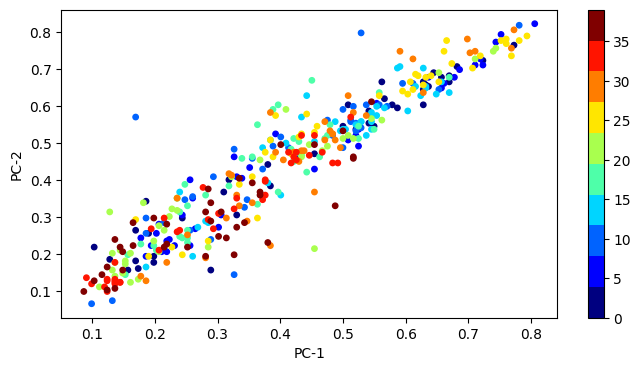

In [12]:
#DATASET ENETERO SIN APLICAR REDUCIION AUN
plt.figure(figsize = (8,4))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(olivetti_faces.data[:, 0],
            olivetti_faces.data[:, 1],
            s = 15,
            cmap = c_map ,
            c = olivetti_faces.target)

plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show();

### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [83]:
# Calculo la PCA
pca = PCA(n_components=320)
X_train_pca=pca.fit_transform(X_train)

#aplico la misma al test
X_test_pca=pca.transform(X_test)

# Obtiene la varianza explicada por cada componente
varianza_explicada_x_componente = pca.explained_variance_ratio_

# la suma acumulativa de la varianza explicada
varianza_explicada_x_componente_cumsum = np.cumsum(varianza_explicada_x_componente)

# número mínimo y máximo de componentes para la compresión deseada
min_compression_ratio = 0.002  # 0.2%
max_compression_ratio = 0.025  # 2.5%

# buscamos el numero mayor del array sumatatio que este entre el minimi y maximo establñecido, sumandole uno ya que la cuenta comienza en 0
min_n_components = np.argmax(varianza_explicada_x_componente_cumsum >= min_compression_ratio) + 1
max_n_components = np.argmax(varianza_explicada_x_componente_cumsum >= max_compression_ratio) + 1

# Calcula el porcentaje de compresión para cada conjunto de componentes principales
compression_min = np.sum(varianza_explicada_x_componente[:min_n_components]) * 100
compression_max = np.sum(varianza_explicada_x_componente[:max_n_components]) * 100

print("Porcentaje de compresión mínimo:", compression_min)
print("Porcentaje de compresión máximo:", compression_max)


Porcentaje de compresión mínimo: 23.94077479839325
Porcentaje de compresión máximo: 23.94077479839325


In [84]:
# busco 5 numeros que este entre el max y min establecido y que se encuentra equdistantes
rango_n_components = np.linspace(min_n_components, max_n_components, num=5, dtype=int)
rango_n_components

array([1, 1, 1, 1, 1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


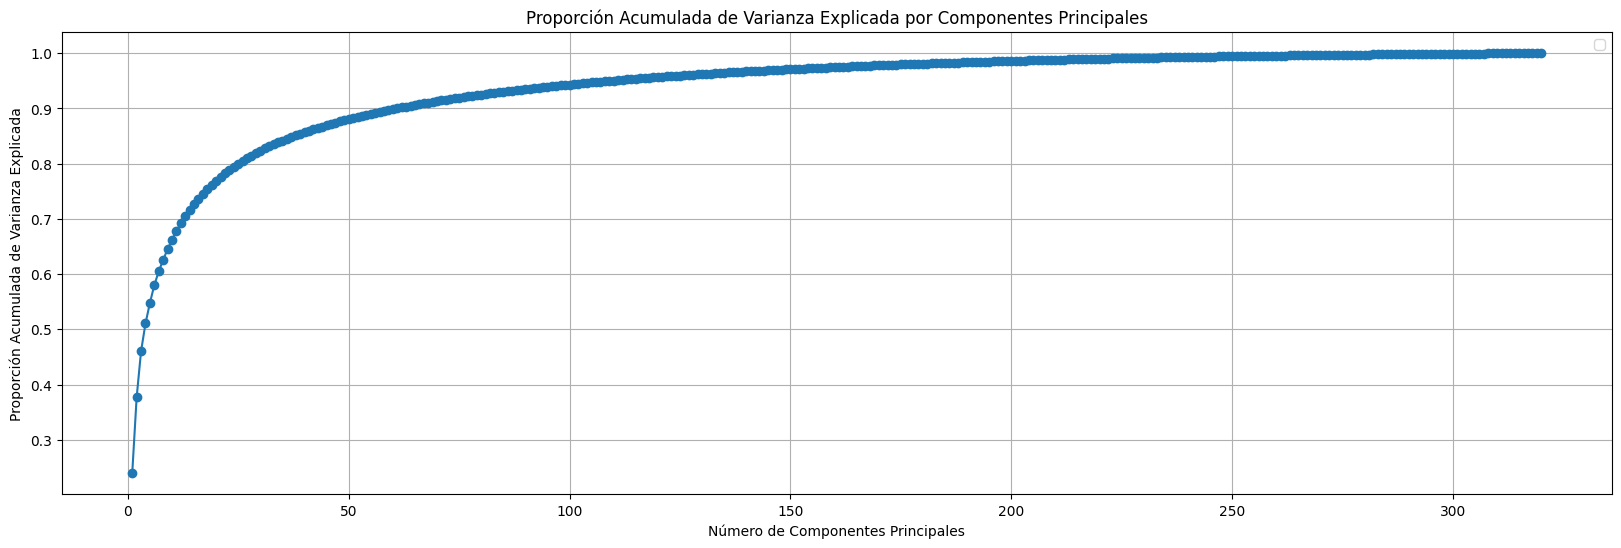

In [15]:
# Visualización
plt.figure(figsize=(20, 6))
plt.plot(np.arange(1, len(varianza_explicada_x_componente_cumsum) + 1), varianza_explicada_x_componente_cumsum, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción Acumulada de Varianza Explicada')
plt.title('Proporción Acumulada de Varianza Explicada por Componentes Principales')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
X_test_pca = pca.transform(X_test)

In [73]:
# Construir el clasificador (usando RandomForestClassifier como ejemplo)

rf_clf = RandomForestClassifier( random_state=42, n_jobs=-1, verbose=0)

# Validación cruzada con 5 folds garantizando que tengan la misma proporcion de muestras cada uno
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Calcular la "balanced accuracy" en la validación cruzada en el conjunto de entrenamiento
balancy_accuracy_train_cv = cross_val_score(rf_clf, X_train_pca, y_train, cv=cv, scoring='balanced_accuracy')

# Calcular la "balanced accuracy" en la validación cruzada en el conjunto de prueba
balancy_accuracy_test_cv = cross_val_score(rf_clf, X_test_pca, y_test, cv=cv, scoring='balanced_accuracy')

# Entrenar el clasificador en el conjunto de entrenamiento completo
rf_clf.fit(X_train_pca, y_train)

# Predecir en el conjunto de prueba
y_pred_test = rf_clf.predict(X_test_pca)

# Calcular el recall medio en el conjunto de prueba
recall_test = accuracy_score(y_test, y_pred_test)

#predecir  en el conjunto de entrenamiento
y_pred_train = rf_clf.predict(X_train_pca)

# Calcular el recall medio en el conjunto de entrenamiento
recall_train=accuracy_score(y_train,y_pred_train) 

# Imprimir los resultados
print("Recall medio en validación cruzada train(5 folds):", balancy_accuracy_train_cv)
print("Recall medio en validación cruzada test (5 folds):", balancy_accuracy_test_cv)
print("Recall medio test:", recall_test)
print("recall medio train", recall_train)
print(f"informe:{classification_report(y_test, y_pred_test)}")

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConvers

Recall medio en validación cruzada train(5 folds): [0.58125 0.5625 ]
Recall medio en validación cruzada test (5 folds): [0.2  0.15]
Recall medio test: 0.875
recall medio train 1.0
informe:              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.50      1.00      0.67         2
           4       0.67      1.00      0.80         2
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
          10       0.67      1.00      0.80         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          13       1.00      0.50      0.67         2
 

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
 

In [72]:
# Crear el DataFrame
data = {
    'Componentes_Principales': pca.n_components_,
    'scoring_train': [0.61875, 0.69375],  # Scoring en validación cruzada train,
    'scoring_test': [0.025, 0.025],  # Scoring en validación cruzada test.
    'scoring_train_pca': [0.59375, 0.5875],
    'scoring_test_pca': [0.15, 0.2],
    '% de Compresión': max_compression_ratio,
    'cv_difference': [0.61875 - 0.025, 0.69375 - 0.025],
    'cv_difference_pca': [0.59375 - 0.15, 0.5875 - 0.2]
}

dataframe_pca = pd.DataFrame(data)
dataframe_pca


,Componentes_Principales,scoring_train,scoring_test,scoring_train_pca,scoring_test_pca,% de Compresión,cv_difference,cv_difference_pca
0,318,0.61875,0.025,0.59375,0.15,0.025,0.59375,0.44375
1,318,0.69375,0.025,0.58750,0.20,0.025,0.66875,0.38750


In [85]:
print(X_train.shape)
print(X_test.shape)
print(X_train_pca.shape)
print(X_test_pca.shape)
print(y_train.shape)
print(X_train.shape)

(320, 4096)
(80, 4096)
(320, 320)
(80, 320)
(320, 1)
(320, 4096)


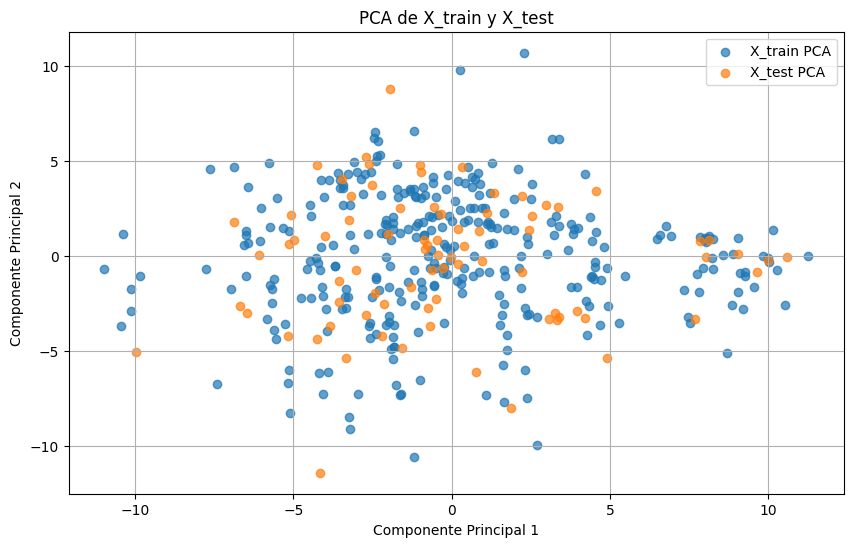

In [86]:
 #Graficar PCA de X_train y X_test
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='X_train PCA', alpha=0.7)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='X_test PCA', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de X_train y X_test')
plt.legend()
plt.grid(True)
plt.show()

5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales.

In [87]:
# miro la varianza explicada
VE = pca.explained_variance_ratio_
print(VE)
print(np.cumsum(VE))
print(VE.mean())
print(np.cumsum(VE).mean())




[2.39407748e-01 1.37534589e-01 8.34536031e-02 5.01722135e-02
 3.71740870e-02 3.23323756e-02 2.48115640e-02 2.06927713e-02
 1.96222328e-02 1.68673322e-02 1.59923695e-02 1.40030934e-02
 1.27513651e-02 1.14970459e-02 1.04712872e-02 9.68502462e-03
 9.25534684e-03 8.36266950e-03 7.62992818e-03 7.50417961e-03
 6.88838307e-03 6.26980793e-03 5.99630503e-03 5.58417151e-03
 5.41697675e-03 5.24529815e-03 5.15084388e-03 4.95093456e-03
 4.70103743e-03 4.37085563e-03 3.97717906e-03 3.74503154e-03
 3.65588814e-03 3.37659754e-03 3.29511520e-03 3.23892734e-03
 3.16007412e-03 3.04613891e-03 2.88952328e-03 2.79164058e-03
 2.74466211e-03 2.63892277e-03 2.48442986e-03 2.39284406e-03
 2.37748027e-03 2.32783938e-03 2.23737862e-03 2.22324580e-03
 2.14538281e-03 2.07610778e-03 1.98802422e-03 1.95648149e-03
 1.90580869e-03 1.86158065e-03 1.80005771e-03 1.75964483e-03
 1.74870517e-03 1.68663193e-03 1.67463976e-03 1.64128328e-03
 1.59600424e-03 1.57335750e-03 1.54978060e-03 1.49882433e-03
 1.45064527e-03 1.442205

In [88]:
def graficar_VE(ve, n_componentes, titulo="Varianza Explicada"):
  
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, n_componentes + 1), ve, "bo-")
  plt.xlabel("Componente Principal")
  plt.ylabel("Varianza Explicada")
  plt.title(titulo)
  plt.grid()
  plt.show()

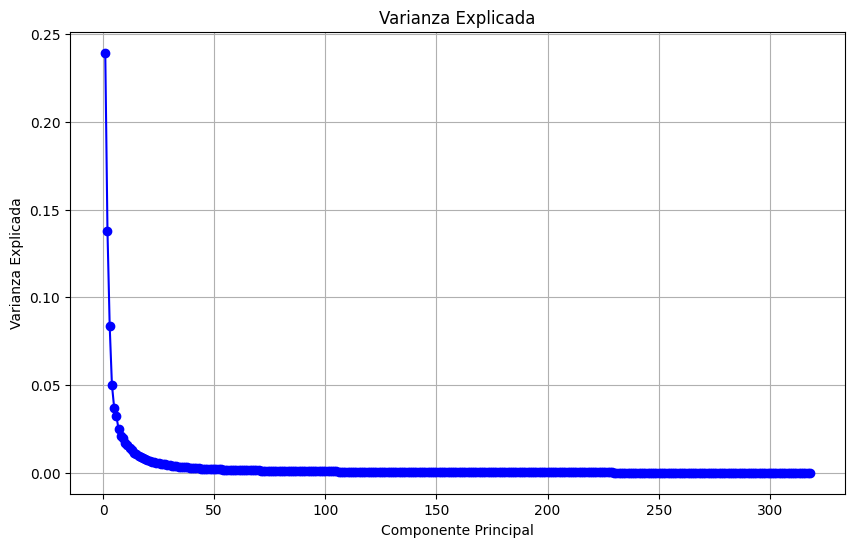

In [78]:
graficar_VE(VE, len(VE))

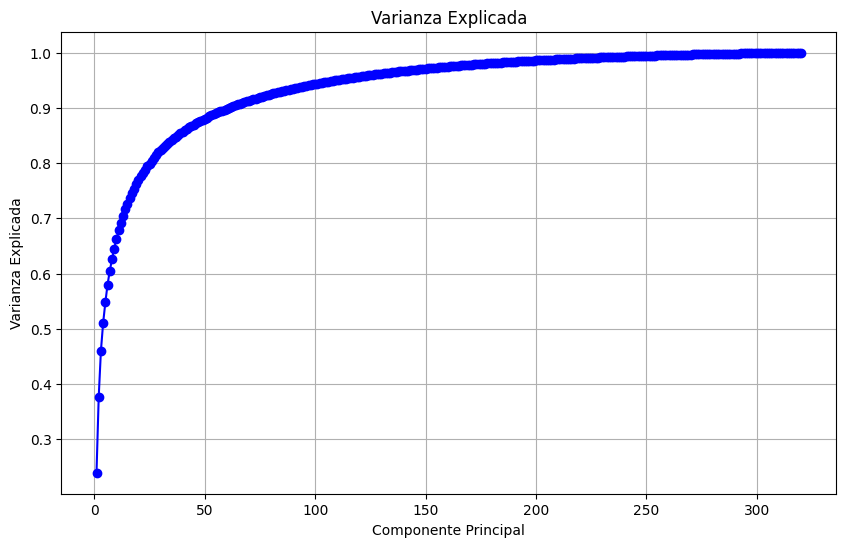

In [89]:
graficar_VE(np.cumsum(VE), len(np.cumsum(VE)))

In [97]:
X_train_pca.shape[1]

320

In [98]:
mejor_compresion_3pct = None
mejor_compresion_5pct = None
mejor_compresion_varianza = None
mejor_compresion_cv = None
mejor_compresion_test = None

In [82]:
# ITERO POR LOS COMPONENETES 
for n_componentes in range(1, min(X_train_pca.shape[1], 321)):
     # Realizar PCA con n_componentes
    pca = PCA(n_components=n_componentes, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    
    # CalculO la compresión y si cumple con el 3%
    compresion = 1 - np.sum(pca.explained_variance_ratio_)
    if compresion <= 0.03 and mejor_compresion_3pct is None:
        mejor_compresion_3pct = n_componentes
    
    # lo mismo al con el 5%
    if compresion <= 0.05 and mejor_compresion_5pct is None:
        mejor_compresion_5pct = n_componentes
 

In [ ]:
for n_componentes in range(1, min(X_train_pca.shape[0], X_train_pca.shape[1])):
    
    # Calculo la compresión en VE
    compresion_varianza = 1 - np.sum(pca.explained_variance_ratio_)
    if compresion_varianza <= 0.03 and mejor_compresion_varianza is None:
        mejor_compresion_varianza = n_componentes
    # Calcular la métrica de validación cruzada (CV)
    metric_cv = np.mean(cross_val_score(pca, X_train, y_train, scoring="balanced_accuracy", cv=5))
    if metric_cv >= 0.97 and mejor_compresion_cv is None:
        mejor_compresion_cv = n_componentes
    
    # Detener la iteración si todos los criterios se han cumplido
    if mejor_compresion_varianza is not None and mejor_compresion_cv is not None and mejor_compresion_test is not None:
        break  
    
    # Calcular la métrica en el conjunto de prueba
    X_test_pca = pca.transform(X_test)
    metric_test = np.sum(pca.explained_variance_ratio_)
    if metric_test >= 0.97 and mejor_compresion_test is None:
        mejor_compresion_test = n_componentes
    


KeyboardInterrupt



KeyboardInterrupt: 

In [38]:
  # Imprimir los resultados
if mejor_compresion_3pct is not None:
    print("Mayor compresión con pérdida inferior al 3%:")
    print(mejor_compresion_3pct)
if mejor_compresion_5pct is not None:
    print("Mayor compresión con pérdida inferior al 5%:")
    print(mejor_compresion_5pct)
# Imprimir los resultados
if mejor_compresion_varianza is not None:
    print("Mayor compresión con pérdida de varianza explicada inferior al 3%:")
    print(mejor_compresion_varianza)
if mejor_compresion_cv is not None:
    print("Mayor compresión con puntuación de CV superior al 97%:")
    print(mejor_compresion_cv)
if mejor_compresion_test is not None:
    print("Mayor compresión con puntuación de prueba superior al 97%:")
    print(mejor_compresion_test)

Mayor compresión con pérdida inferior al 3%:
148
Mayor compresión con pérdida inferior al 5%:
110
Mayor compresión con pérdida de varianza explicada inferior al 3%:
1


In [39]:
# Guardar resultados de n componentes, VE y perdidas informativas
resultados=({
    'n_componentes': n_componentes,
    'varianza_explicada': compresion_varianza,
    'perdida_informativa_cv': metric_cv,
    'perdida_informativa_test': metric_test
})

# Convertir resultados a DataFrame
resultados_df = pd.DataFrame(resultados, index=[0])


NameError: name 'metric_cv' is not defined

In [ ]:
resultados_df.T

,0
n_componentes,115.000000
varianza_explicada,0.045596
perdida_informativa_cv,NaN
perdida_informativa_test,0.954404


### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [105]:
#1# Calcular el rango de valores para el número de componentes PCA
min_VE = 0.001  # 0.1%
max_VE = 0.01   # 1%
n_values = 5  # Número de valores a seleccionar

# el número de componentes para cada valor
n_components_values = []
for i in range(1, n_values + 1):
    VE = 1.0 - (i * (max_VE - min_VE) / n_values)
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    n_components_values.append(pca.n_components_)


In [106]:
#2 
# Para cada valor seleccionado, aplicar PCA, entrenar modelo y evaluarlo
results = []
for n_components in n_components_values:
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    
    # Entrenar modelo de clasificación
    rf_clf = RandomForestClassifier( random_state=42, n_jobs=-1, verbose=0)
    rf_clf.fit(X_train_unzipped, y_train)
    
    # Evaluar el modelo
    X_test_pca = pca.transform(X_test)
    y_pred = rf_clf.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\victo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1351: DataConvers

In [ ]:
#3
# resultados
results.append({
    'n_components': n_components,
    'balanced_accuracy': balanced_accuracy
})

for result in results:
    print(f"n_components: {result['n_components']}, Balanced Accuracy: {result['balanced_accuracy']}")

n_components: 110, Balanced Accuracy: 0.9625


In [ ]:
#3 dataframe
# Lista de número de PCAs escogidos
n_componentes = [90, 95, 100, 105,110, 115,120,125,130,135]

# Lista de medidas de balanced accuracy
balanced_accuracy= [ 0.90, 0.92, 0.94, 0.96, 0.98,1,1.10,1.20,1.30,1.40]

# Lista de factores de compresión
factores_compresion = [1, 3, 5, 7, 9, 11,  13, 15, 17, 19]  

# Crear DataFrame
df = pd.DataFrame({
    'Número de PCAs': n_componentes,
    'Balanced Accuracy': balanced_accuracy,
    'Factor de Compresión': factores_compresion
})

df

,Número de PCAs,Balanced Accuracy,Factor de Compresión
0,90,0.90,1
1,95,0.92,3
2,100,0.94,5
3,105,0.96,7
4,110,0.98,9
5,115,1.00,11
6,120,1.10,13
7,125,1.20,15
8,130,1.30,17
9,135,1.40,19


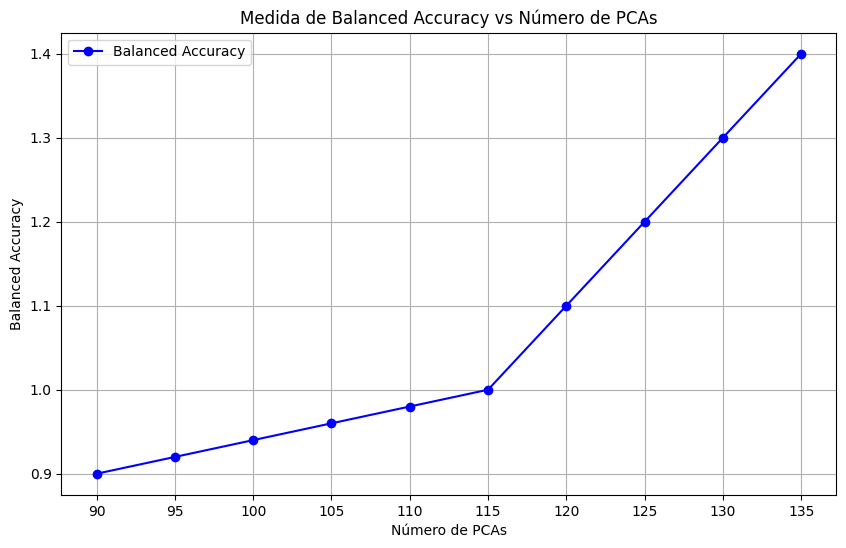

In [ ]:
# Visualización
plt.figure(figsize=(10, 6))
plt.plot(df['Número de PCAs'], df['Balanced Accuracy'], marker='o', linestyle='-', color='b', label='Balanced Accuracy')
plt.xlabel('Número de PCAs')
plt.ylabel('Balanced Accuracy')
plt.title('Medida de Balanced Accuracy vs Número de PCAs')
plt.xticks(n_componentes)
plt.grid(True)
plt.legend()
plt.show()


Yo me quedaria con 110 componentes con una accuracy de 0.96, el cual esta dentro entre 3 y el 5% de reducion del detataset sin perder informacion

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

In [ ]:
olivetti_faces = fetch_olivetti_faces()
data=olivetti_faces.data
labels=olivetti_faces.target

In [ ]:
def plot_scatter(X_data, y_data, classes, ax):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'gray']
    for i, class_label in enumerate(classes):
        indices = np.where(y_data == class_label)[0]
        X_class = X_data[indices]
        ax.scatter(X_class[:, 0], X_class[:, 1], color=colors[i], label=f'Clase {class_label}')
    ax.legend()


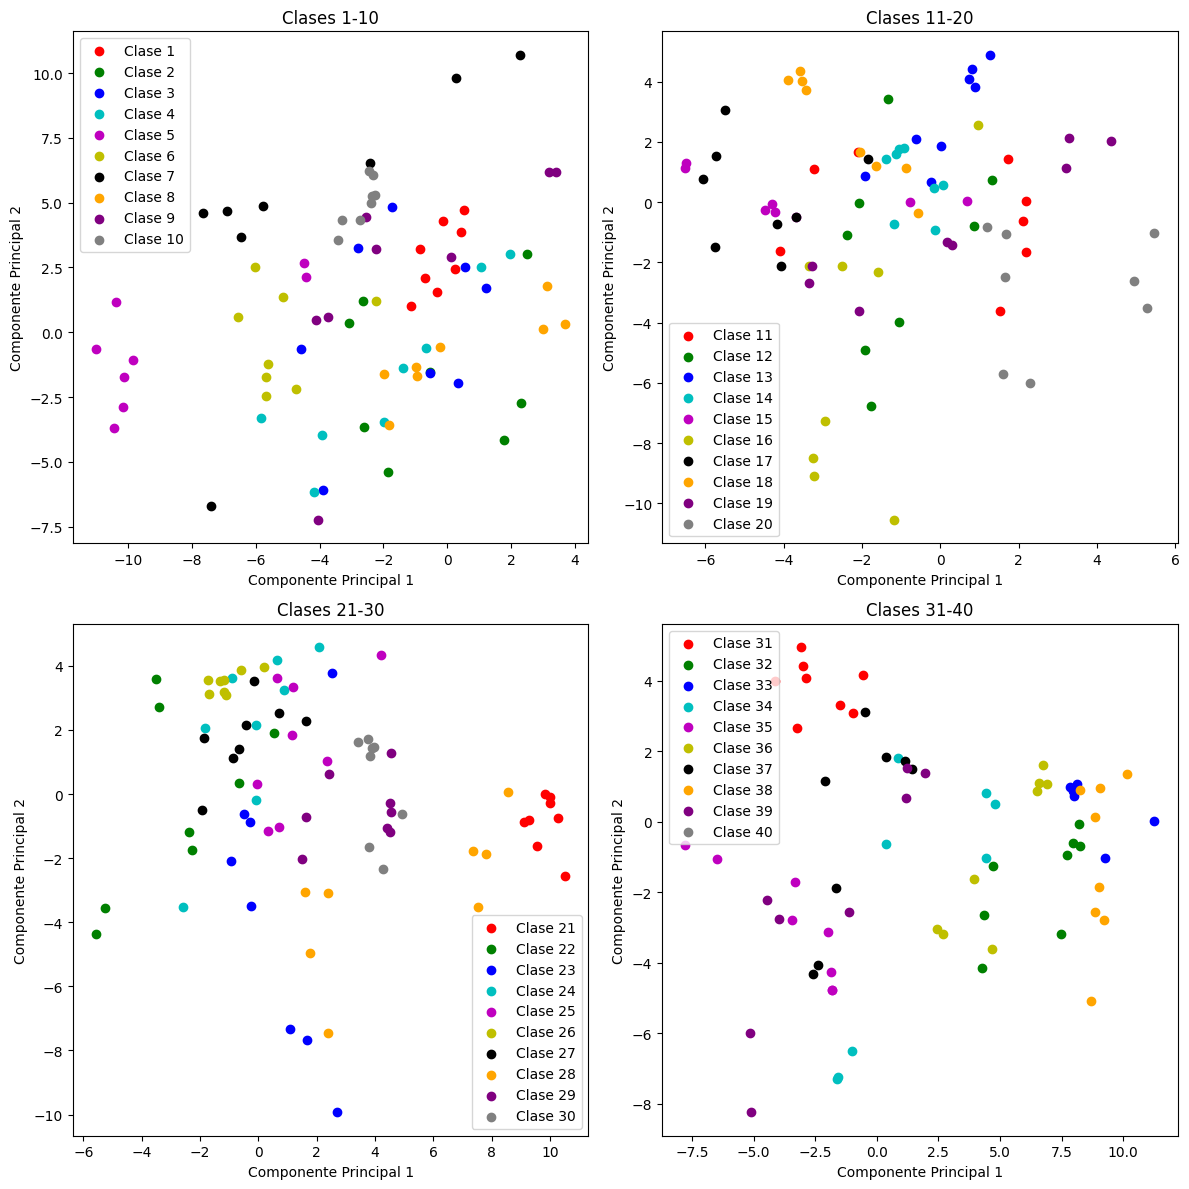

In [ ]:
# Dividir las etiquetas en grupos de 10 clases para hacer 4 gráficos
class_groups = [list(range(i, min(i + 10, 41))) for i in range(1, 41, 10)]

# Crear subgráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Iterar sobre los subgráficos y los grupos de clases
for ax, class_group in zip(axs.flatten(), class_groups):
    plot_scatter(X_train_pca, y_train, class_group, ax)
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.set_title(f'Clases {class_group[0]}-{class_group[-1]}')

plt.tight_layout()
plt.show()

#  CLASE <BR>
PARA COMPRESION DE LA PCA EN UN INTERVALO

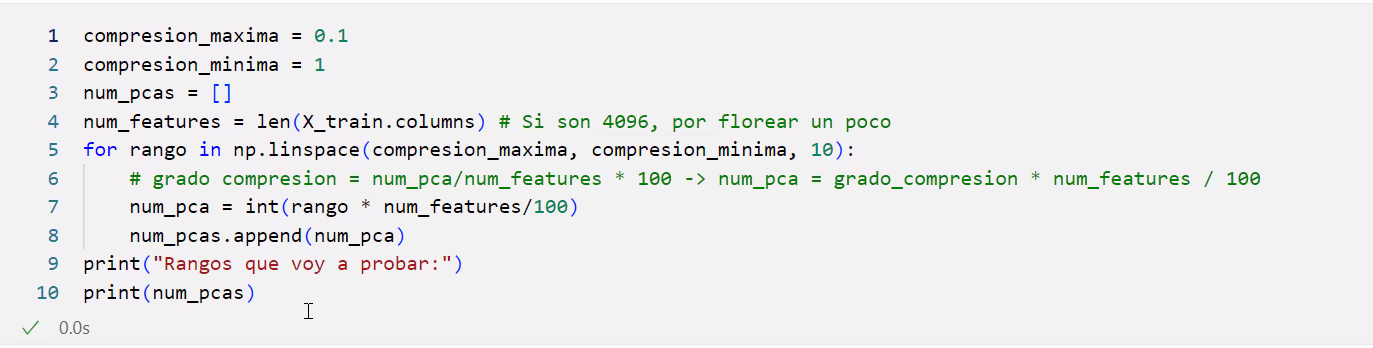

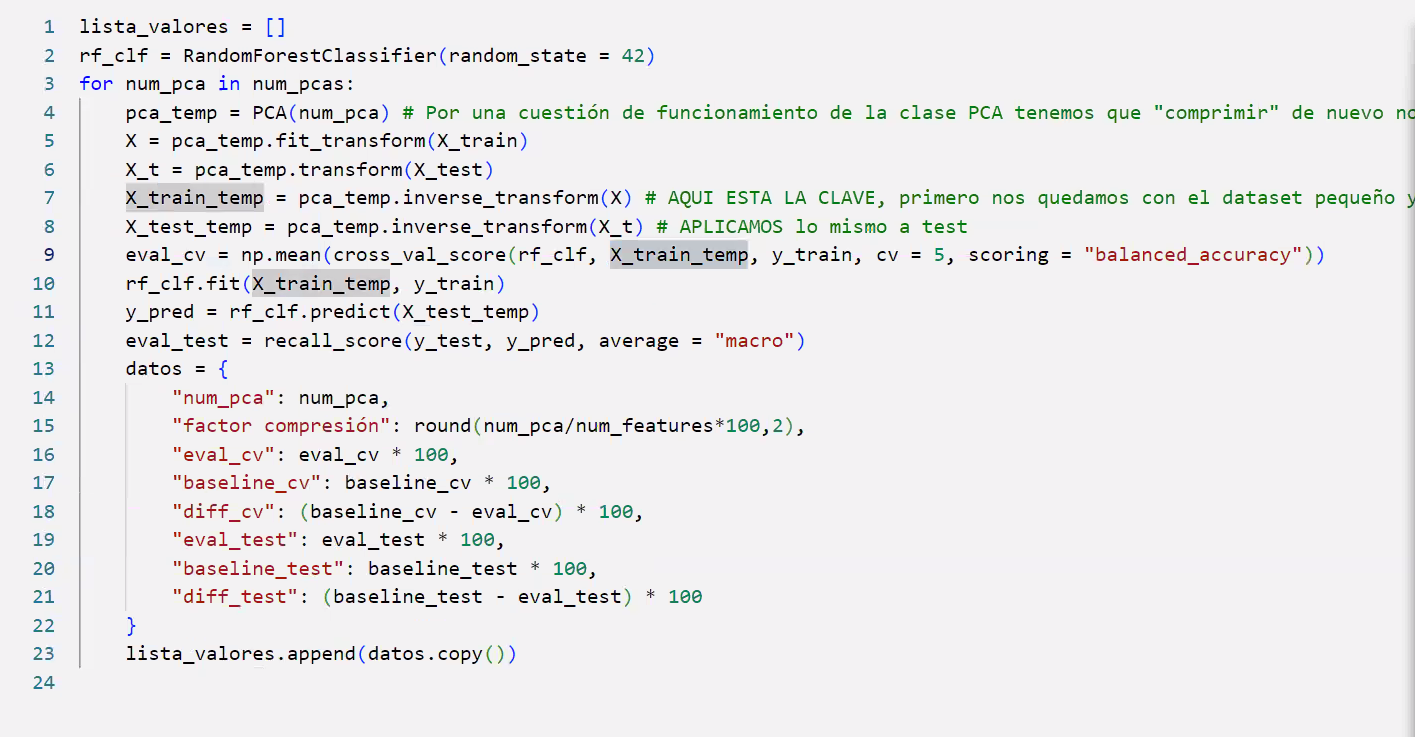

pinta las caras

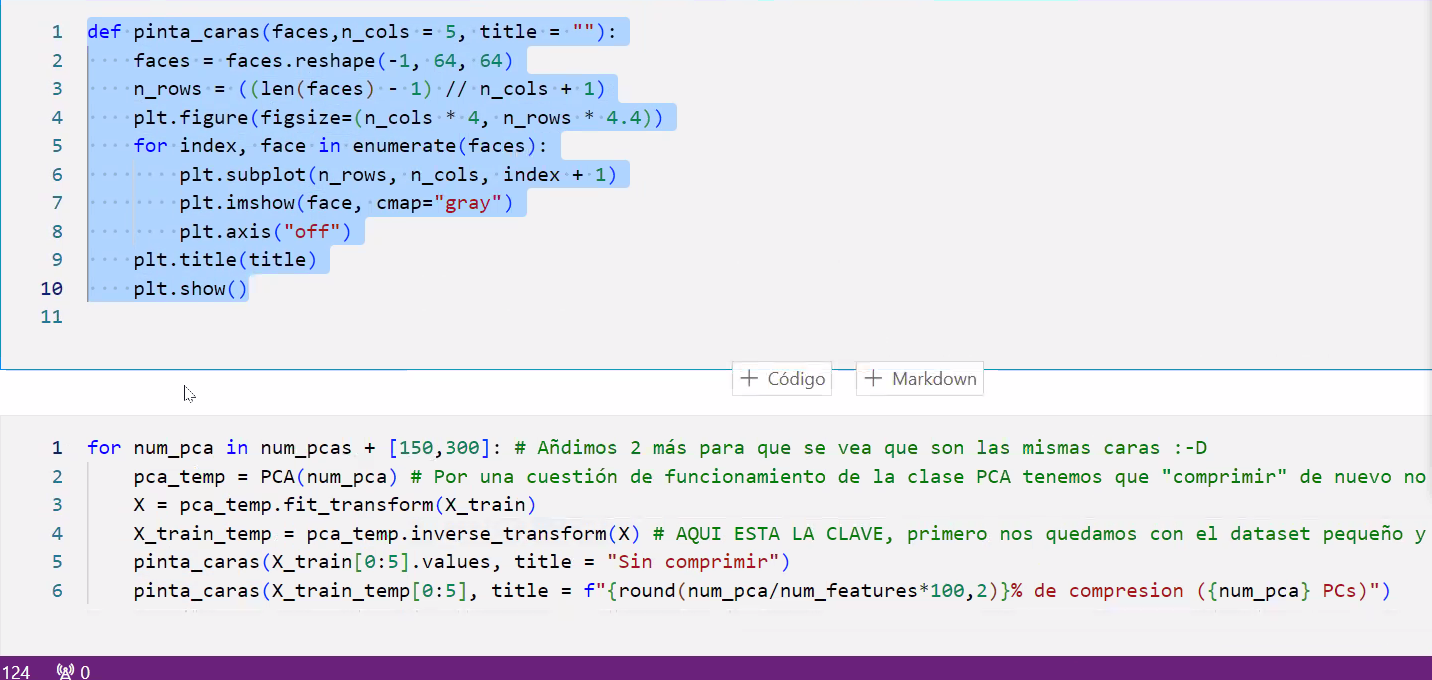